## Μοντέλο με τη χρήση Νευρωνικών Δικτύων για την πρόβλεψη μετοχών

In [186]:
# Import necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM,Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

In [187]:
# Download stock data
symbol = 'AMZN'  # Example with Apple stock
start_date = '2018-01-01'
end_date = '2023-11-30'
df = yf.download(symbol, start=start_date, end=end_date)
df['Date'] = df.index

[*********************100%%**********************]  1 of 1 completed


In [188]:
# 1. Data Cleaning and Preprocessing
# Check for missing values and handle them
df.isnull().sum()
df.dropna(inplace=True)

In [189]:
# Feature Selection - Using 'Close' Prices
close_prices = df['Close'].values.reshape(-1, 1)

In [190]:
# Normalizing the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)

In [191]:
# Preparing the Data for LSTM
def create_dataset(dataset, time_step=60):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

In [192]:
# Splitting data into train and test sets
time_step = 60
X, y = create_dataset(scaled_data, time_step)
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size,:], X[train_size:len(X),:]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

In [193]:
# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [194]:
# Building and Training LSTM Model
model = Sequential()
model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=(time_step, 1)))
model.add(Bidirectional(LSTM(50)))
model.add(Dense(25))
model.add(Dense(1))

In [195]:
adam_optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=adam_optimizer, loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=1, epochs=5)  # Adjust epochs as needed

Epoch 1/5


1141/1141 [==============================] - 52s 37ms/step - loss: 0.0039
Epoch 2/5
1141/1141 [==============================] - 42s 37ms/step - loss: 0.0015
Epoch 3/5
1141/1141 [==============================] - 41s 36ms/step - loss: 0.0011
Epoch 4/5
1141/1141 [==============================] - 44s 39ms/step - loss: 0.0011
Epoch 5/5
1141/1141 [==============================] - 42s 36ms/step - loss: 8.2743e-04


In [196]:
# Model Evaluation
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

9/9 [==============================] - 0s 30ms/step


In [197]:
# Transform back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [198]:
# Calculate the start index for test predictions
test_start_index = len(scaled_data) - len(test_predict) - 1

In [199]:
# Adjusting the indices for train and test predictions
trainPredictPlot = np.empty_like(scaled_data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[time_step:len(train_predict) + time_step, :] = train_predict

In [200]:
testPredictPlot = np.empty_like(scaled_data)
testPredictPlot[:, :] = np.nan
testPredictPlot[test_start_index:test_start_index + len(test_predict), :] = test_predict

In [201]:
# Calculate MAE, MSE, RMSE for training data
train_mae = mean_absolute_error(y_train, scaler.inverse_transform(model.predict(X_train)))
train_mse = mean_squared_error(y_train, scaler.inverse_transform(model.predict(X_train)))
train_rmse = np.sqrt(train_mse)

 3/36 [=>............................] - ETA: 1s

36/36 [==============================] - 1s 31ms/step


In [202]:
# Calculate MAE, MSE, RMSE for testing data
test_mae = mean_absolute_error(y_test, scaler.inverse_transform(model.predict(X_test)))
test_mse = mean_squared_error(y_test, scaler.inverse_transform(model.predict(X_test)))
test_rmse = np.sqrt(test_mse)

9/9 [==============================] - 0s 28ms/step


In [203]:
print("Training Data Evaluation:")
print("MAE:", train_mae)
print("MSE:", train_mse)
print("RMSE:", train_rmse)

Training Data Evaluation:
MAE: 126.01976384680762
MSE: 17069.406594090247
RMSE: 130.64993912777092


In [204]:
print("\nTesting Data Evaluation:")
print("MAE:", test_mae)
print("MSE:", test_mse)
print("RMSE:", test_rmse)


Testing Data Evaluation:
MAE: 116.93260156943995
MSE: 13999.6413497986
RMSE: 118.32008007856739


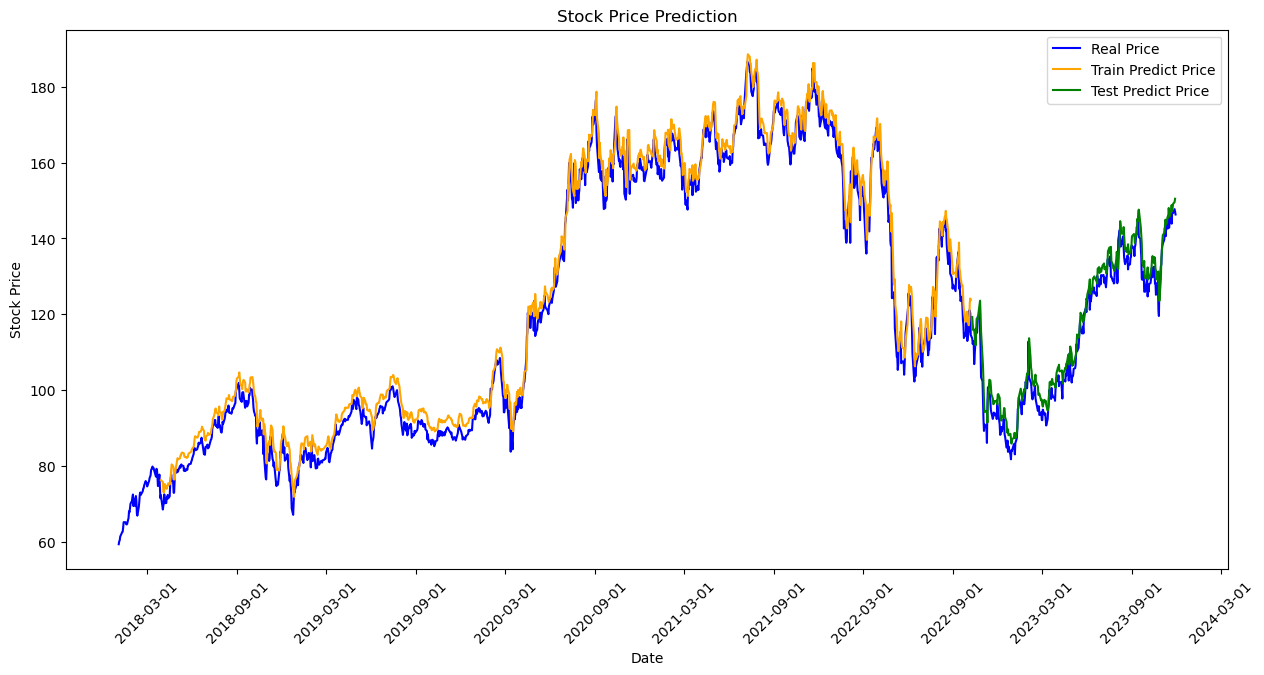

In [205]:
# Plotting with dates on x-axis at 6-month intervals
plt.figure(figsize=(15,7))
plt.plot(df.index, scaler.inverse_transform(scaled_data), label='Real Price', color='blue')
plt.plot(df.index, trainPredictPlot, label='Train Predict Price', color='orange')
plt.plot(df.index, testPredictPlot, label='Test Predict Price', color='green')

# Formatting the dates on x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [211]:
# Define the number of future days to predict
future_days = 5
future_predictions = []

# Get the last time_step days from the dataset
last_time_step_data = scaled_data[-time_step:]

# Reshape it in the form expected by the LSTM ([samples, time steps, features])
current_batch = last_time_step_data.reshape((1, time_step, 1))

# Predict future days
for i in range(future_days):
    # Get the prediction value for the first batch
    future_pred = model.predict(current_batch)[0]
    
    # Append the prediction into the array
    future_predictions.append(future_pred)
    
    # Use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:], [[future_pred]], axis=1)

# Inverse transform to get the actual stock prices
future_predictions = scaler.inverse_transform(future_predictions)

# Create a pandas Series with the predicted values and corresponding future dates
future_dates = pd.date_range(start=df.index[-1], periods=future_days, freq='B')  # 'B' denotes business day frequency
future_dates_series = pd.Series(future_dates, name='Date')
future_predictions_series = pd.Series(np.reshape(future_predictions, (future_days,)), name='Predicted Close')

# Combine the dates and predictions into a DataFrame
future_predictions_df = pd.concat([future_dates_series, future_predictions_series], axis=1)

1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 39ms/step


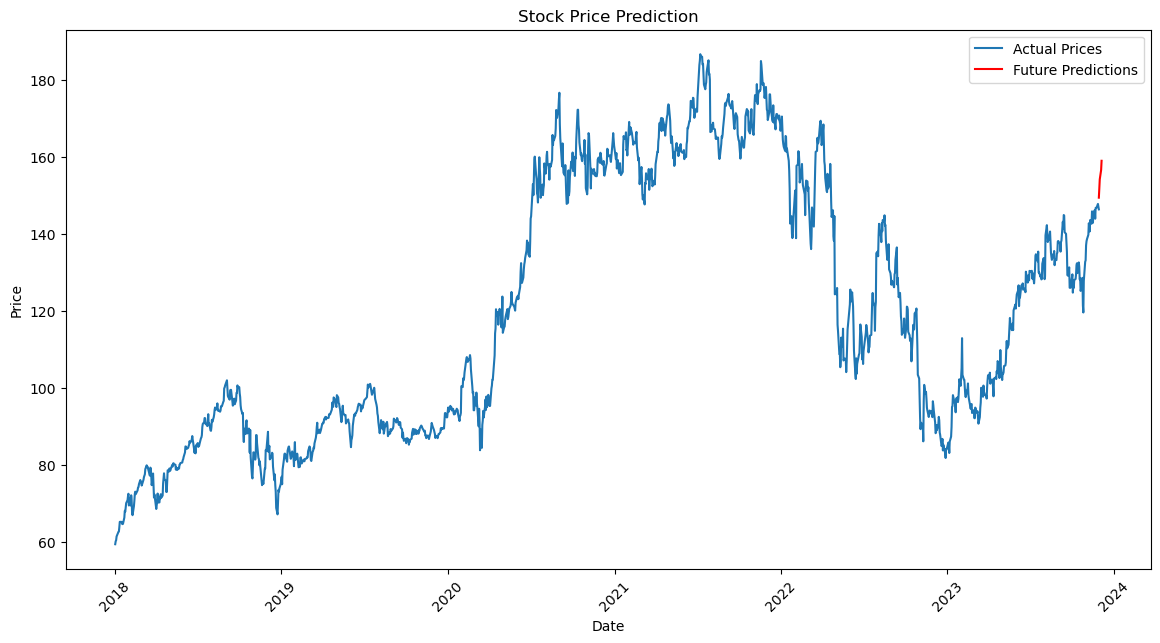

In [212]:
# Plot actual data
plt.figure(figsize=(14,7))
plt.plot(df['Close'], label='Actual Prices')

# Plot predicted future data
plt.plot(future_predictions_df.set_index('Date'), label='Future Predictions', color='red')

plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.show()